In [1]:
import json, os, sys, statistics, matplotlib
sys.path.append("../scripts/formalism")
sys.path.append("../scripts")
from diffuser_real.dataset import real_dataset
from dataset import *
import pandas as pd
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from collections import defaultdict
from plottable import Table, ColumnDefinition

In [2]:
def Transpose(triplets, apply_to_relations=[1]):
    tmp = []
    for t in triplets:
        if t[-1] in apply_to_relations: tmp.append((t[1], t[0], t[-1]))
        else: tmp.append(t)
    return tmp
def COMPLETENESS_tworoles(num_nouns, df):
    CPL_at_r1 = len(set(df["O1"])) / num_nouns
    CPL_at_r2 = len(set(df["O2"])) / num_nouns
    return round(CPL_at_r1*100, 2), round(CPL_at_r2*100, 2)
def BALANCE_tworoles(num_nouns, df):
    summation = 0
    count_all = len(df)
    for i in range(num_nouns):
        count_O_c_i = len(df[(df.O1 == i) | (df.O2 == i)])
        count_O1_c_i = len(df[(df.O1 == i)])
        count_O2_c_i = len(df[(df.O2 == i)])
        delta = 0
        if count_O1_c_i > 0:
            delta -= count_O1_c_i * np.log(count_O1_c_i / count_O_c_i)
        if count_O2_c_i > 0:
            delta -= count_O2_c_i * np.log(count_O2_c_i / count_O_c_i)
        summation +=  delta
    summation /= count_all*2
    summation /= np.log(2) # normalize by log(M), M = num_roles
    return round(summation*100, 2)

def customize_legend_col(ax, val):
    ax.set_aspect("equal")
    radius = min(max(ax.get_xlim()), max(ax.get_ylim())) / 3
    center = (statistics.mean(ax.get_xlim()), statistics.mean(ax.get_ylim()))
    circle = plt.Circle(center, radius, transform=ax.transData, color=val)
    ax.add_patch(circle)
    return [circle]

## Synthetic Dataset

In [26]:
N = list(range(30, 91, 10))
SPLITS = ["split2", "split3", "split4", "split5", "split6", "split7", "split8", "split9", "split12", "split13", "split14", "split15", "split16", "split17", "split18", "split19", "split20", "split21", "split22", "split23", "split24"]

### map split_method to legend color used in paper
default_color = "ghostwhite"
image_skew_colors = defaultdict(lambda: default_color)
image_skew_colors.update({
    "split24": "tab:blue",
    "split15": "tab:orange",
    "split14": "tab:green",
    "split2": "tab:red",
    "split20": "tab:purple",
    "split17": "tab:brown",
    "split13": "tab:pink",
    "split12": "tab:gray",
})
linguistic_skew_colors = defaultdict(lambda: default_color)
linguistic_skew_colors.update({
    "split23": "tab:blue",
    "split7": "tab:orange",
    "split21": "tab:green",
    "split19": "tab:red",
    "split5": "tab:purple",
})

In [4]:
def create_synthetic_df(split, num_nouns, transpose=False):
    nouns = list(range(num_nouns))
    train_triplets, test_triplets = eval(f"create_data_{split}")(nouns)
    if transpose: train_triplets, test_triplets = Transpose(train_triplets), Transpose(test_triplets)
    df = pd.DataFrame(train_triplets, columns =['O1', 'O2', 'R'])
    return df

In [5]:
def plot_CPL_table(scores, title, map_to_colors):
    scores = dict(sorted(scores.items(), key=lambda x: x[1][0]))

    column_names = ["legend", "split_method"] + [f"#objs = {n}" for n in N]
    cmap = []
    df = pd.DataFrame(columns=column_names)
    for i, s in enumerate(scores):
        df.loc[i] = [i, s] + [f"{x[0]:.1f} | {x[1]:.1f}" for x in scores[s]]
        cmap.append(map_to_colors[s])
    df = df.set_index("legend")

    fig = plt.figure(figsize=(14, 8))
    ax = fig.add_subplot(111)

    col_defs = [ColumnDefinition(
                name="legend",
                border="",
                width=0.6,
                textprops={
                    "ha": "center",
                    "bbox": {"boxstyle": "circle", "pad": 0.05},
                    "alpha": 0,
                },
                cmap=matplotlib.colors.ListedColormap(cmap)
            ),
            ColumnDefinition(
                name="split_method",
                title="split_method",
                border="left right",
                width=1.0,
                textprops={"ha": "left", "fontsize": 10},
            )] + [ 
            ColumnDefinition(
                name=f"#objs = {n}",
                title=f"#objs = {n}",
                border="",
                textprops={"ha": "right", "fontsize": 10},
            ) for n in N]

    tab = Table(df,
                ax=ax,
                column_definitions = col_defs,
                column_border_kw={"linewidth": 0.5, "color": "black", "linestyle": "-", "alpha": 0.2},
                footer_divider=True,
                )
    ax.set_title(title)
    plt.show()

 24%|██▍       | 5/21 [00:00<00:00, 46.32it/s]

100%|██████████| 21/21 [00:00<00:00, 39.98it/s]


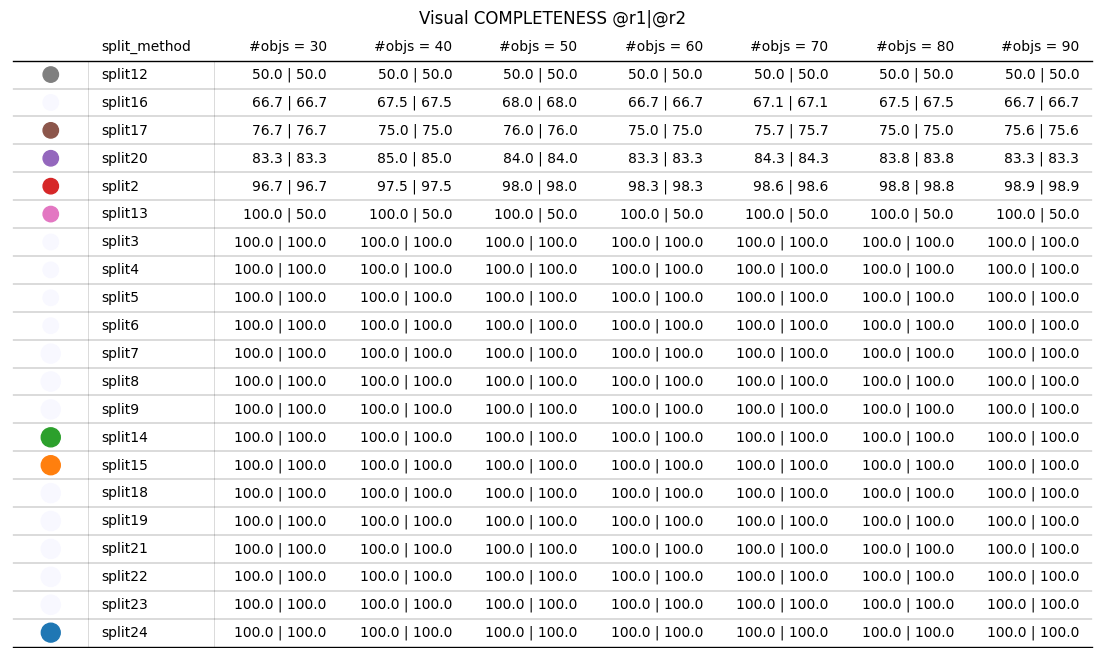

In [6]:
scores = defaultdict(list)
for split in tqdm(SPLITS):
    for num_nouns in N:
        df = create_synthetic_df(split, num_nouns, transpose=False)
        scores[split].append(COMPLETENESS_tworoles(num_nouns, df))
plot_CPL_table(scores, "Visual COMPLETENESS @r1|@r2", image_skew_colors)

  0%|          | 0/21 [00:00<?, ?it/s]

100%|██████████| 21/21 [00:00<00:00, 32.92it/s]


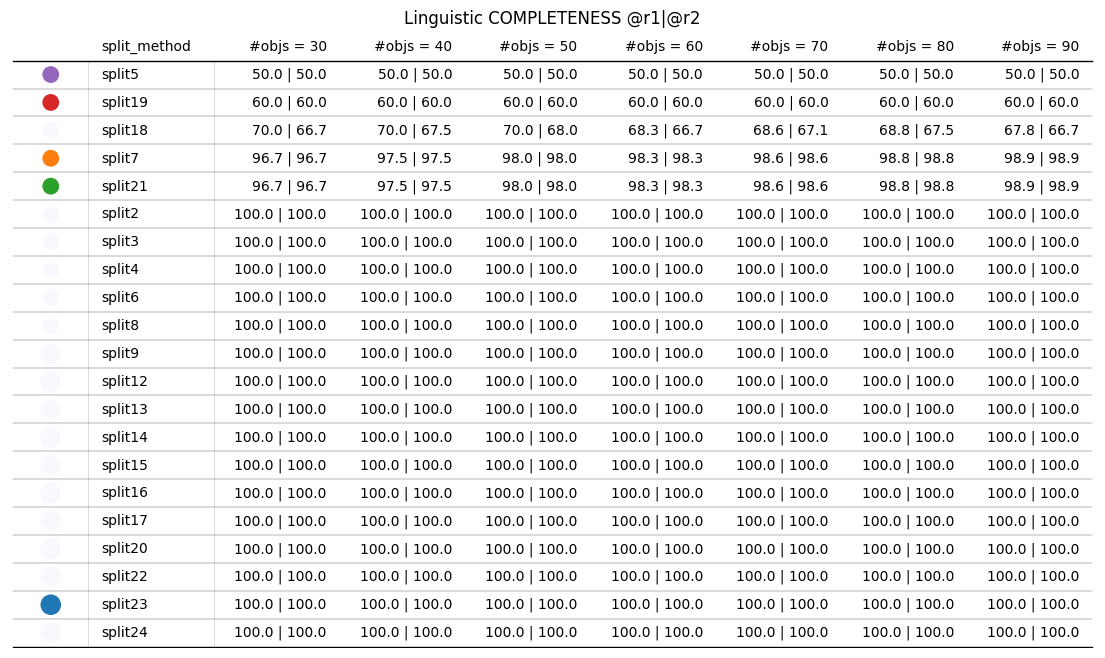

In [7]:
scores = defaultdict(list)
for split in tqdm(SPLITS):
    for num_nouns in N:
        df = create_synthetic_df(split, num_nouns, transpose=True)
        scores[split].append(COMPLETENESS_tworoles(num_nouns, df))
plot_CPL_table(scores, "Linguistic COMPLETENESS @r1|@r2", linguistic_skew_colors)

In [8]:
def plot_BLC_table(scores, title, map_to_colors):
    scores = dict(sorted(scores.items(), key=lambda x: x[1][0]))

    column_names = ["legend", "split_method"] + [f"#objs = {n}" for n in N]
    cmap = []
    df = pd.DataFrame(columns=column_names)
    for i, s in enumerate(scores):
        df.loc[i] = [i, s] + [f"{x:.1f}" for x in scores[s]]
        cmap.append(map_to_colors[s])
    df = df.set_index("legend")

    fig = plt.figure(figsize=(14, 7))
    ax = fig.add_subplot(111)

    col_defs = [ColumnDefinition(
                name="legend",
                border="",
                width=0.6,
                textprops={
                    "ha": "center",
                    "bbox": {"boxstyle": "circle", "pad": 0.05},
                    "alpha": 0,
                },
                cmap=matplotlib.colors.ListedColormap(cmap)
            ),
            ColumnDefinition(
                name="split_method",
                title="split_method",
                border="left right",
                width=1.0,
                textprops={"ha": "left", "fontsize": 11,},
            )] + [ 
            ColumnDefinition(
                name=f"#objs = {n}",
                title=f"#objs = {n}",
                border="",
                textprops={"ha": "right", "fontsize": 11},
            ) for n in N]

    tab = Table(df,
                ax=ax,
                column_definitions = col_defs,
                column_border_kw={"linewidth": 0.5, "color": "black", "linestyle": "-", "alpha": 0.2},
                footer_divider=True,
                )
    ax.set_title(title)
    plt.show()

100%|██████████| 21/21 [00:05<00:00,  4.17it/s]


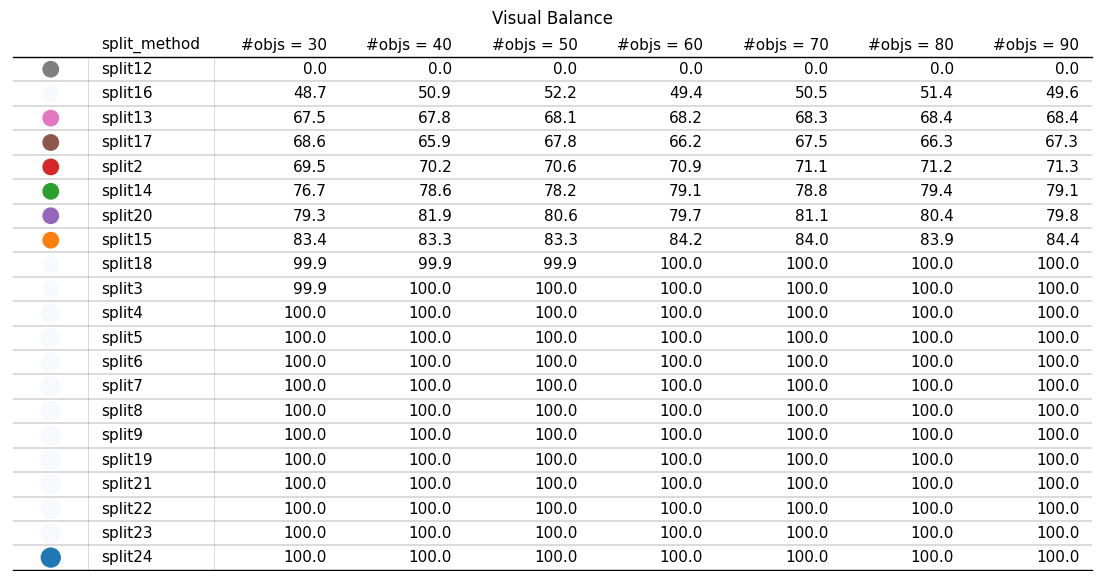

In [9]:
scores = defaultdict(list)
for split in tqdm(SPLITS):
    for num_nouns in N:
        df = create_synthetic_df(split, num_nouns, transpose=False)
        scores[split].append(BALANCE_tworoles(num_nouns, df))
plot_BLC_table(scores, "Visual Balance", image_skew_colors)

100%|██████████| 21/21 [00:05<00:00,  4.08it/s]


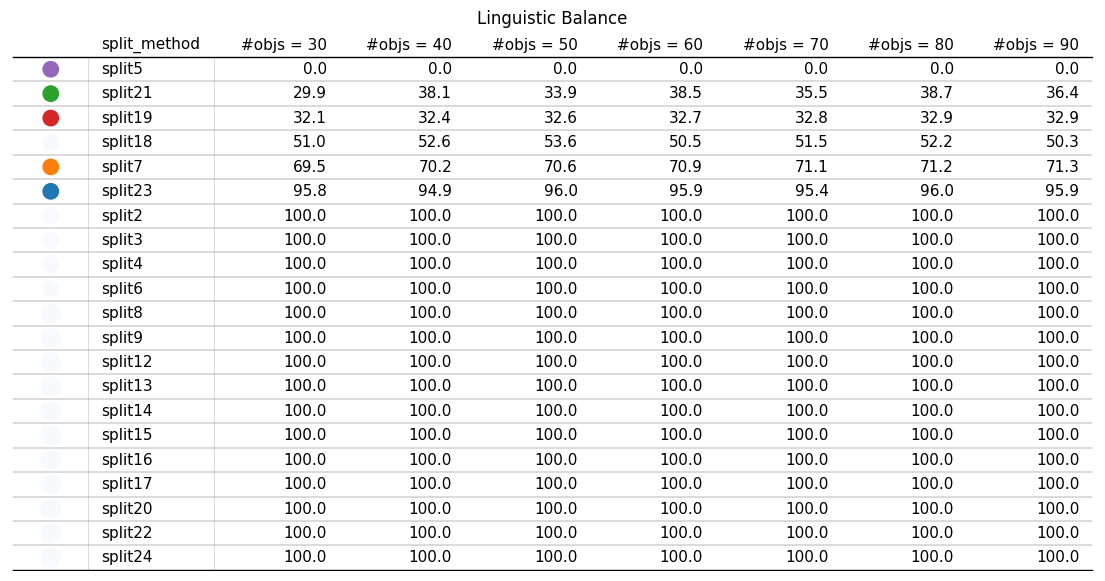

In [10]:
scores = defaultdict(list)
for split in tqdm(SPLITS):
    for num_nouns in N:
        df = create_synthetic_df(split, num_nouns, transpose=True)
        scores[split].append(BALANCE_tworoles(num_nouns, df))
plot_BLC_table(scores, "Linguistic Balance", linguistic_skew_colors)

In [11]:
def vanilla_COVERAGE_tworoles(num_nouns, df):
    coverage = len(set([tuple(df.loc[i].tolist()) for i in range(len(df))])) / (num_nouns*(num_nouns-1)*2)
    return round(coverage*100, 2)

In [27]:
(
    CPL_at_r1_scores_V, CPL_at_r2_scores_V, BLC_scores_V,
    CPL_at_r1_scores_L, CPL_at_r2_scores_L, BLC_scores_L, 
    COVERAGE_scores
) = (
    defaultdict(list), defaultdict(list), defaultdict(list),
    defaultdict(list), defaultdict(list), defaultdict(list), 
    defaultdict(list),
)
for split in tqdm(SPLITS):
    for num_nouns in N:
        df = create_synthetic_df(split, num_nouns, transpose=False)
        CPL_at_r1, CPL_at_r2 = COMPLETENESS_tworoles(num_nouns, df)
        CPL_at_r1_scores_V[split].append(CPL_at_r1)
        CPL_at_r2_scores_V[split].append(CPL_at_r2)
        BLC_scores_V[split].append(BALANCE_tworoles(num_nouns, df))
        COVERAGE_scores[split].append(vanilla_COVERAGE_tworoles(num_nouns, df))
        df = create_synthetic_df(split, num_nouns, transpose=True)
        CPL_at_r1, CPL_at_r2 = COMPLETENESS_tworoles(num_nouns, df)
        CPL_at_r1_scores_L[split].append(CPL_at_r1)
        CPL_at_r2_scores_L[split].append(CPL_at_r2)
        BLC_scores_L[split].append(BALANCE_tworoles(num_nouns, df))
    CPL_at_r1_scores_V[split] = "%.1f" % statistics.median(CPL_at_r1_scores_V[split])
    CPL_at_r2_scores_V[split] = "%.1f" % statistics.median(CPL_at_r2_scores_V[split])
    BLC_scores_V[split] = "%.1f" % statistics.median(BLC_scores_V[split])
    COVERAGE_scores[split] = round(statistics.median(COVERAGE_scores[split]))
    CPL_at_r1_scores_L[split] = "%.1f" % statistics.median(CPL_at_r1_scores_L[split])
    CPL_at_r2_scores_L[split] = "%.1f" % statistics.median(CPL_at_r2_scores_L[split])
    BLC_scores_L[split] = "%.1f" % statistics.median(BLC_scores_L[split])

COVERAGE_scores = dict(sorted(COVERAGE_scores.items(), key=lambda x: x[1]))

column_names = ["Coverage", "split_method", "legend_V", "CPL@r1_V", "CPL@r2_V", "BLC_V", "legend_L", "CPL@r1_L", "CPL@r2_L", "BLC_L"]
cmap_V, cmap_L = [], []
df = pd.DataFrame(columns=column_names)
for i, s in enumerate(COVERAGE_scores):
    df.loc[i] = [COVERAGE_scores[s], s, 
                 image_skew_colors[s], CPL_at_r1_scores_V[s], CPL_at_r2_scores_V[s], BLC_scores_V[s], 
                 linguistic_skew_colors[s], CPL_at_r1_scores_L[s], CPL_at_r2_scores_L[s], BLC_scores_L[s]]
    cmap_V.append(image_skew_colors[s])
    cmap_L.append(linguistic_skew_colors[s])
df = df.set_index("Coverage")


100%|██████████| 21/21 [00:20<00:00,  1.04it/s]


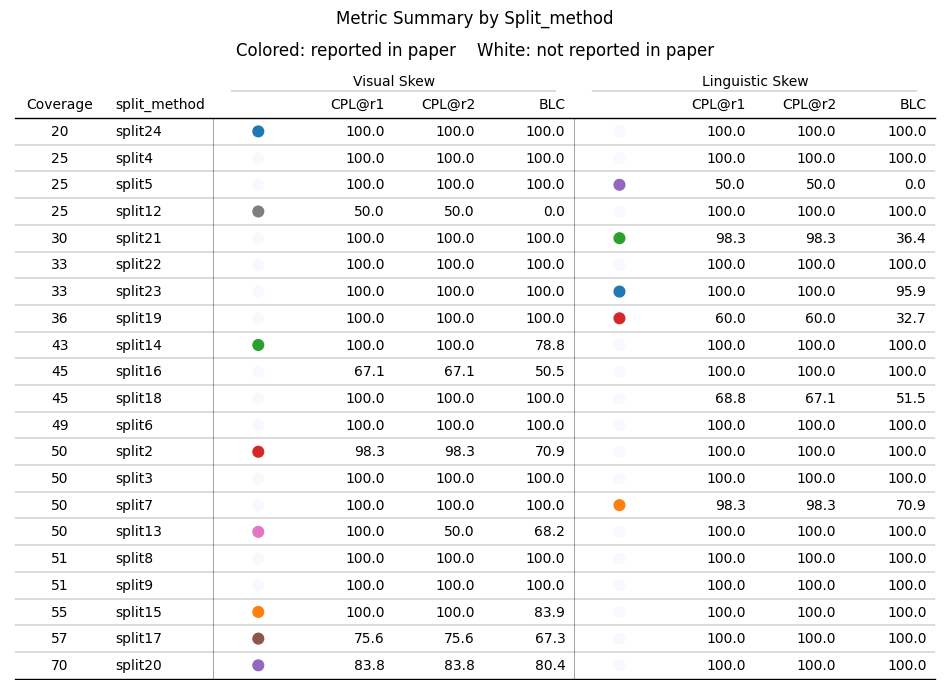

In [28]:
## Plot metric summary for all splits in diffuser_icons experiments

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

col_defs = [
        ColumnDefinition(
            name="Coverage",
            title="Coverage",
            border="",
            width=0.5,
            textprops={"ha": "center", "fontsize": 10},
        ), 
        ColumnDefinition(
            name="split_method",
            title="split_method",
            border="right",
            width=0.6,
            textprops={"ha": "left", "fontsize": 10},
        ), 
        ColumnDefinition(
            name="legend_V",
            title="",
            border="",
            width=0.5,
            textprops={"ha": "right"},
            group="Visual Skew",
            plot_fn=customize_legend_col,
        )
        ] + [ 
        ColumnDefinition(
            name=n,
            title=n.split("_")[0],
            border="",
            width=0.5,
            textprops={"ha": "right", "fontsize": 10},
            group="Visual Skew",
        ) for n in ["CPL@r1_V", "CPL@r2_V", "BLC_V"]
        ] + [
            ColumnDefinition(
            name="legend_L",
            title="",
            border="left",
            width=0.5,
            textprops={"ha": "right"},
            group="Linguistic Skew",
            plot_fn=customize_legend_col,
        )
        ] + [
        ColumnDefinition(
            name=n,
            title=n.split("_")[0],
            border="",
            width=0.5,
            textprops={"ha": "right", "fontsize": 10},
            group="Linguistic Skew",
        ) for n in ["CPL@r1_L", "CPL@r2_L", "BLC_L"]
        ]


tab = Table(df,
            ax=ax,
            column_definitions = col_defs,
            column_border_kw={"linewidth": 0.5, "color": "black", "linestyle": "-", "alpha": 0.5},
            footer_divider=True,
            )
ax.set_title("Metric Summary by Split_method\nColored: reported in paper    White: not reported in paper", linespacing=2)
plt.show()

fig.savefig("../scripts/diffuser_icons/metric_summary.png", bbox_inches='tight', dpi=150)

## Whatsup Dataset

In [14]:
SPLITS = ["splitA", "splitB", "splitC", "splitD", "splitE", "splitF", "splitG", "splitH", "splitI", "splitJ", "splitK", "splitT", "splitU", "splitV", "splitW", "splitX", "splitZ"]

### map split_method to legend color used in paper
default_color = "ghostwhite"
image_skew_colors = defaultdict(lambda: default_color)
image_skew_colors.update({
    "splitZ": "yellow",
    "splitU": "yellow",
    "splitV": "yellow",
    "splitT": "yellow",
    "splitX": "yellow",
    "splitD": "yellow",
})
linguistic_skew_colors = defaultdict(lambda: default_color)
linguistic_skew_colors.update({
    "splitG": "yellow",
    "splitA": "yellow",
    "splitB": "yellow",
    "splitH": "yellow",
    "splitI": "yellow",
    "splitE": "yellow",
})

In [15]:
annotations = json.load(open("../data/aggregated/whatsup_vlm_b_lr_autofill_remove_sun_rem_pho.json", "r"))
#imdir="<largefiles_dir>/skewed_relations_T2I/data" # [Important]: update this to the correct path
imdir="/data/yingshac/clevr_control/data/" 

In [20]:
(
    CPL_at_r1_scores_V, CPL_at_r2_scores_V, BLC_scores_V,
    CPL_at_r1_scores_L, CPL_at_r2_scores_L, BLC_scores_L, 
    COVERAGE_scores, num_unique_images
) = ({}, {}, {}, {}, {}, {}, {}, {})

r2i = {"left of": 0, "right of": 1} # hardcoded

for split in SPLITS:
    
    D = real_dataset(imdir, annotations, imsize=(32, 64), subsample_method=f"subsample_whatsup_{split}")
    n2i = {n:i for i, n in enumerate(D.classes)}
    num_nouns = len(D.classes)
    coverage = round(len(D)*100/(len(n2i)*(len(n2i)-1)*len(r2i)))
    COVERAGE_scores[split] = coverage
    
    train_triplets = [(n2i[d[-1][0]], n2i[d[-1][1]], r2i[d[-1][-1]]) for d in D.data]
    tmp = Transpose(train_triplets, apply_to_relations=[1])
    #print("{} #unique images = {}/154".format(split, len(set([x[:2] for x in tmp]))))
    num_unique_images[split] = len(set([x[:2] for x in tmp]))

    df = pd.DataFrame(train_triplets, columns =['O1', 'O2', 'R'])
    CPL_at_r1, CPL_at_r2 = COMPLETENESS_tworoles(num_nouns, df)
    BLC = BALANCE_tworoles(num_nouns, df)
    CPL_at_r1_scores_L[split] = f"{CPL_at_r1:.1f}"
    CPL_at_r2_scores_L[split] = f"{CPL_at_r2:.1f}"
    BLC_scores_L[split] = f"{BLC:.1f}"

    train_triplets = Transpose(train_triplets, apply_to_relations=[1])
    df = pd.DataFrame(train_triplets, columns =['O1', 'O2', 'R'])
    CPL_at_r1, CPL_at_r2 = COMPLETENESS_tworoles(num_nouns, df)
    BLC = BALANCE_tworoles(num_nouns, df)
    CPL_at_r1_scores_V[split] = f"{CPL_at_r1:.1f}"
    CPL_at_r2_scores_V[split] = f"{CPL_at_r2:.1f}"
    BLC_scores_V[split] = f"{BLC:.1f}"


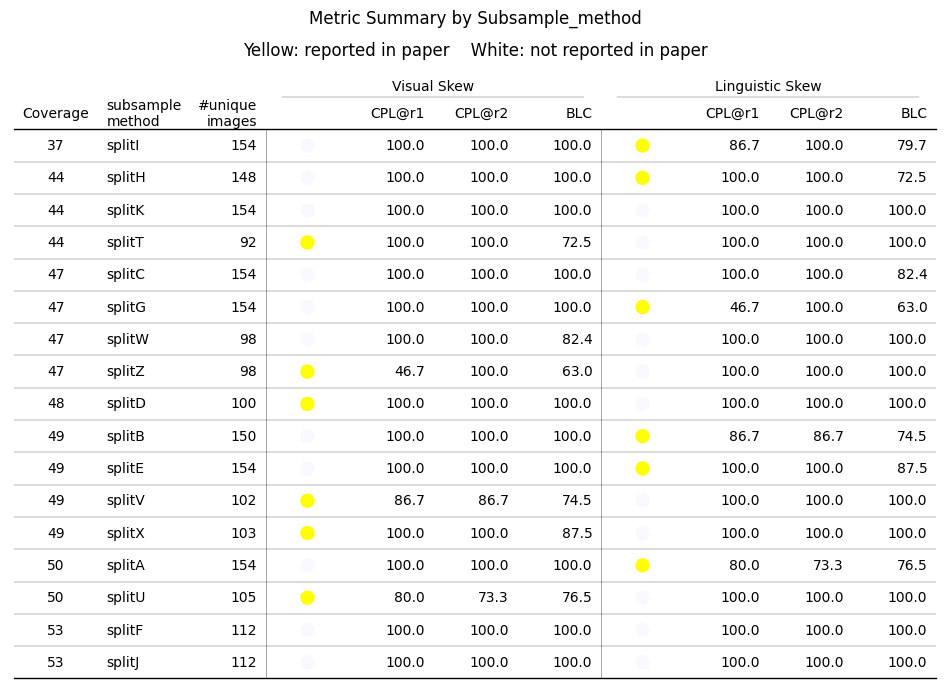

In [24]:
COVERAGE_scores = dict(sorted(COVERAGE_scores.items(), key=lambda x: x[1]))

column_names = ["Coverage", "subsample_method", "#unique_imgs", "legend_V", "CPL@r1_V", "CPL@r2_V", "BLC_V", "legend_L", "CPL@r1_L", "CPL@r2_L", "BLC_L"]
cmap_V, cmap_L = [], []
df = pd.DataFrame(columns=column_names)
for i, s in enumerate(COVERAGE_scores):
    df.loc[i] = [COVERAGE_scores[s], s, num_unique_images[s],
                 image_skew_colors[s], CPL_at_r1_scores_V[s], CPL_at_r2_scores_V[s], BLC_scores_V[s], 
                 linguistic_skew_colors[s], CPL_at_r1_scores_L[s], CPL_at_r2_scores_L[s], BLC_scores_L[s]]
    cmap_V.append(image_skew_colors[s])
    cmap_L.append(linguistic_skew_colors[s])
df = df.set_index("Coverage")

## Plot metric summary for all splits in diffuser_icons experiments

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

col_defs = [
        ColumnDefinition(
            name="Coverage",
            title="Coverage",
            border="",
            width=0.5,
            textprops={"ha": "center", "fontsize": 10},
        ), 
        ColumnDefinition(
            name="subsample_method",
            title="subsample\nmethod",
            border="",
            width=0.5,
            textprops={"ha": "left", "fontsize": 10},
        ), 
        ColumnDefinition(
            name="#unique_imgs",
            title="#unique\nimages",
            border="right",
            width=0.5,
            textprops={"ha": "right", "fontsize": 10},
        ),
        ColumnDefinition(
            name="legend_V",
            title="",
            border="",
            width=0.5,
            textprops={"ha": "right"},
            group="Visual Skew",
            plot_fn=customize_legend_col,
        )
        ] + [ 
        ColumnDefinition(
            name=n,
            title=n.split("_")[0],
            border="",
            width=0.5,
            textprops={"ha": "right", "fontsize": 10},
            group="Visual Skew",
        ) for n in ["CPL@r1_V", "CPL@r2_V", "BLC_V"]
        ] + [
            ColumnDefinition(
            name="legend_L",
            title="",
            border="left",
            width=0.5,
            textprops={"ha": "right"},
            group="Linguistic Skew",
            plot_fn=customize_legend_col,
        )
        ] + [
        ColumnDefinition(
            name=n,
            title=n.split("_")[0],
            border="",
            width=0.5,
            textprops={"ha": "right", "fontsize": 10},
            group="Linguistic Skew",
        ) for n in ["CPL@r1_L", "CPL@r2_L", "BLC_L"]
        ]


tab = Table(df,
            ax=ax,
            column_definitions = col_defs,
            column_border_kw={"linewidth": 0.5, "color": "black", "linestyle": "-", "alpha": 0.5},
            footer_divider=True,
            )
ax.set_title("Metric Summary by Subsample_method\nYellow: reported in paper    White: not reported in paper", linespacing=2)
plt.show()

fig.savefig("../scripts/diffuser_real/metric_summary.png", bbox_inches='tight', dpi=150)